# Importing the Libraries

In [2900]:
# !pip install --upgrade scikit-learn
# !pip install --upgrade imbalanced-learn

In [2901]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#Sampling
from collections import Counter
from imblearn.over_sampling import SMOTE

# Importing the dataset

In [2902]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [2903]:
dataset_copy = dataset.copy()

In [2904]:
dataset.shape

(41188, 21)

#### Reordering the columns order as numerical to categorical

In [2905]:
def change_column_type_object_to_categorical(df):
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [2906]:
change_column_type_object_to_categorical(dataset_copy)

In [2907]:
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder the dataset as starting with numerical columns then categorical
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]

In [2908]:
dataset_copy.dtypes

age                  int64
duration             int64
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
poutcome          category
y                 category
dtype: object

## Defining required functions:

In [2909]:
def visualize_features(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, kde=True, color='skyblue')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [2910]:
def visualize_target_feature(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, hue='y', multiple='stack', palette='Set2')
    plt.title(f"Distribution of 'y' within {column_name} Groups")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [2911]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f"Boxplot of {column_name} (with Outliers)")
    plt.xlabel(column_name)
    plt.tight_layout()
    plt.show()

In [2912]:
def visualize(df,column_name):
    visualize_features(df,column_name)
    visualize_target_feature(df,column_name)
    visualize_outliers(df, column_name)

In [2913]:
def remove_outliers_by_quantiles(df, column_name, lower_quantile=0.08, upper_quantile=0.92):
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)
    df.drop(df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index, inplace=True)

In [2914]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    labels = []
    for i in range(len(thresholds) - 1):
        label = f"{col_name}_({thresholds[i]}_{thresholds[i+1]}]"
        mask = (df[col_name] > thresholds[i]) & (df[col_name] <= thresholds[i+1])
        df.loc[mask, f'{col_name}_group'] = label
        labels.append(label)

In [2915]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    percentages = {}
    total_samples = len(df)
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [2916]:
def calculate_success_rate(df, feature_column, target_column, lower_bound,upper_bound):
    # Filter the DataFrame for the specific condition
    filtered_df = df[(df[feature_column] >= lower_bound) & (df[feature_column] <= upper_bound)].copy()
    # Group by the feature column and calculate the rate of 'yes' for each unique value
    grouped = filtered_df.groupby(feature_column)[target_column].apply(lambda x: (x == 'yes').mean())
    success_rate = grouped.mean()
    return grouped, success_rate

In [2917]:
def generate_start_end_threshold(df, col_name, increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    return start, end

In [2918]:
def generate_threshold(df,col_name,increment_range):
    start, end = generate_start_end_threshold(df,col_name,increment_range)
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds

In [2919]:
def correlation_heatmap(df,numerical_col):
    ## taking from https://github.com/bowcai/bank-analysis/blob/main/bank-analysis.ipynb
    fig= plt.figure(figsize=(8,8))

    corr = df[numerical_col].corr()
    mask = np.triu(df[numerical_col].corr())

    axes = fig.add_axes([0, 0, 1, 1])
    sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
                linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

# Data Visualization

In [2920]:
# for col in dataset_copy.columns:
#     visualize_features(dataset_copy,col)

# Handling outliers

In [2921]:
numerical_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [2922]:
for col_name in numerical_columns:
    remove_outliers_by_quantiles(dataset_copy,col_name)

# Handling missing values

In [2923]:
# Only categorical features has missing values
print(dataset_copy[categorical_columns].isin(['unknown']).sum())

job             153
marital          33
education       752
default        4830
housing         468
loan            468
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64


In [2924]:
# Replacing the "unknown" with np.nan
dataset_copy.replace('unknown', np.nan, inplace=True)
dataset_copy.fillna(dataset_copy.mode().iloc[0], inplace=True)

# Feature Extraction:

##### 1-) "Age"

In [2925]:
age_threshold = generate_threshold(dataset_copy,'age',5)
print(age_threshold)

[25, 30, 35, 40, 45, 50, 55, 60]


In [2926]:
print_extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

(25_30] = 0.1113, samples:2184
(30_35] = 0.2554, samples:5011
(35_40] = 0.2112, samples:4144
(40_45] = 0.1613, samples:3165
(45_50] = 0.1363, samples:2674
(50_55] = 0.1051, samples:2062
(55_60] = 0.0193, samples:379


In [2927]:
extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

##### 2-) "duration"

In [2928]:
duration_threshold = generate_threshold(dataset_copy,'duration',100)
print(duration_threshold)

[0, 100, 200, 300, 400, 500, 600, 700]


In [2929]:
print_extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

(0_100] = 0.2052, samples:4025
(100_200] = 0.3734, samples:7325
(200_300] = 0.2052, samples:4025
(300_400] = 0.1136, samples:2229
(400_500] = 0.0595, samples:1167
(500_600] = 0.0395, samples:775
(600_700] = 0.0037, samples:73


In [2930]:
extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

##### 3-) "pdays"

In [2931]:
dataset_copy['pdays_group'] = dataset_copy['pdays']
dataset_copy.loc[dataset_copy['pdays'] <= 100, 'pdays_group'] = 0
dataset_copy.loc[dataset_copy['pdays'] > 100, 'pdays_group'] = 1

In [2932]:
print(dataset_copy['pdays_group'].value_counts())

pdays_group
1    19619
Name: count, dtype: int64


##### 4-) "emp.var.rate"

In [2933]:
dataset_copy['emp.var.rate_sign'] = dataset_copy['emp.var.rate']
dataset_copy.loc[dataset_copy['emp.var.rate'] < 0, 'emp.var.rate_sign'] = -1    # negative employment variation rate
dataset_copy.loc[dataset_copy['emp.var.rate'] > 0, 'emp.var.rate_sign'] = 1     # positive employment variation rate

In [2934]:
print(dataset_copy['emp.var.rate_sign'].value_counts())

emp.var.rate_sign
 1.0    14526
-1.0     5093
Name: count, dtype: int64


##### 5-) "cons.conf.idx"

In [2935]:
cons_conf_idx_threshold = generate_threshold(dataset_copy,'cons.conf.idx',5)
print(cons_conf_idx_threshold)

[-50.0, -45.0, -40.0, -35.0]


In [2936]:
print_extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

(-50.0_-45.0] = 0.1148, samples:2252
(-45.0_-40.0] = 0.4605, samples:9035
(-40.0_-35.0] = 0.4247, samples:8332


In [2937]:
extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

# Encoding features:

In [2938]:
print(categorical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [2939]:
label_encoded_features = ['age_group','duration_group','cons.conf.idx_group',
                          'education','default','housing','loan','month',
                          'day_of_week','poutcome','marital','contact','y']
onehot_encoded_features = ['job']

In [2940]:
ohe = OneHotEncoder(dtype='int32')
label_encoder = LabelEncoder()

for col in onehot_encoded_features:
    transformed = ohe.fit_transform(dataset_copy[[col]])
    dataset_copy[ohe.categories_[0]] = transformed.toarray()

for column in label_encoded_features:
    dataset_copy[column] = label_encoder.fit_transform(dataset_copy[column])

In [2941]:
dataset_copy.dtypes

age                       int64
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
emp.var.rate            float64
cons.price.idx          float64
cons.conf.idx           float64
euribor3m               float64
nr.employed             float64
job                    category
marital                   int32
education                 int32
default                   int32
housing                   int32
loan                      int32
contact                   int32
month                     int32
day_of_week               int32
poutcome                  int32
y                         int32
age_group                 int32
duration_group            int32
pdays_group               int64
emp.var.rate_sign       float64
cons.conf.idx_group       int32
admin.                    int32
blue-collar               int32
entrepreneur              int32
housemaid                 int32
management                int32
retired 

# Feature Reduction:

<Axes: >

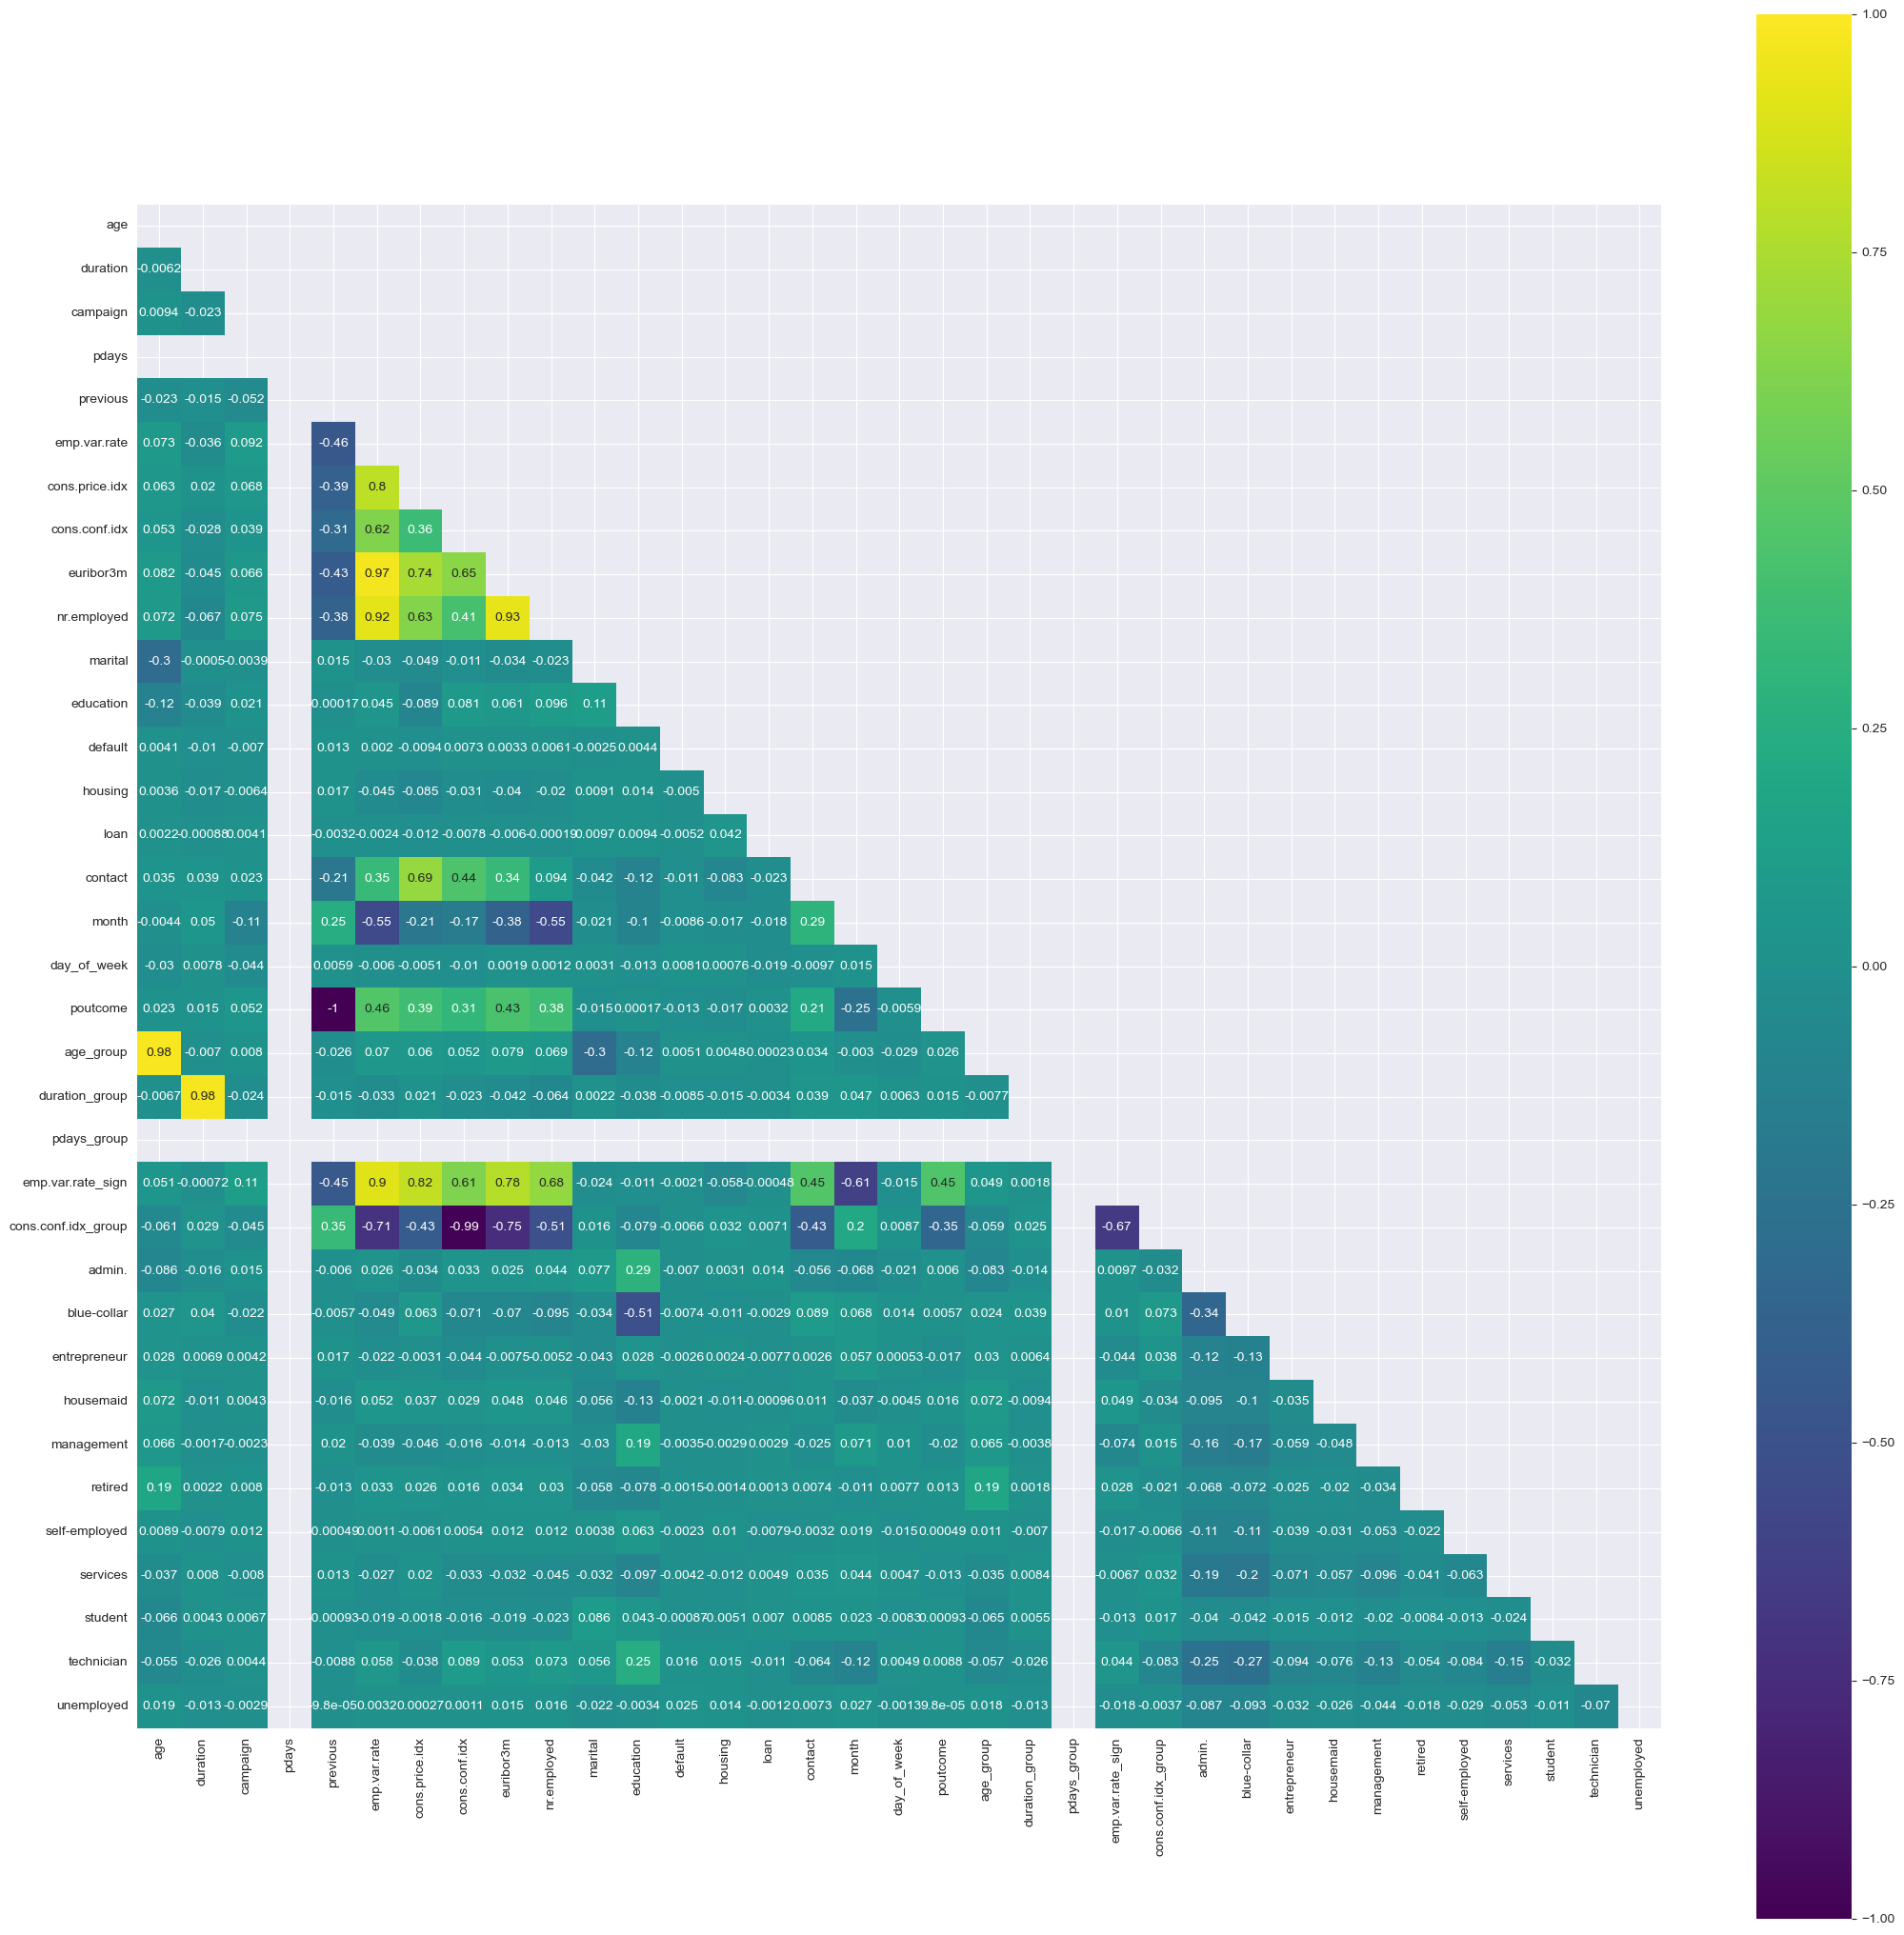

In [2942]:
fig= plt.figure(figsize=(20,20))
df = dataset_copy.drop(['y','job'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [2943]:
# selected_features = ['age_group','duration_group','campaign','previous','emp.var.rate_sign','cons.conf.idx_group',
#                      'marital','default','housing','loan','contact','month','day_of_week','admin.', 'blue-collar', 'entrepreneur',
#                      'housemaid', 'management', 'retired', 'self-employed', 'services',
#                      'student', 'technician', 'unemployed','y']
# dataset_selected = dataset_copy[selected_features].copy()

In [2944]:
# Remove the one of the high correlated features
dataset_selected= dataset_copy.drop(['age','duration','pdays','cons.price.idx','job','poutcome','emp.var.rate','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
numerical_columns = dataset_selected.select_dtypes(include='number').columns.tolist()

<Axes: >

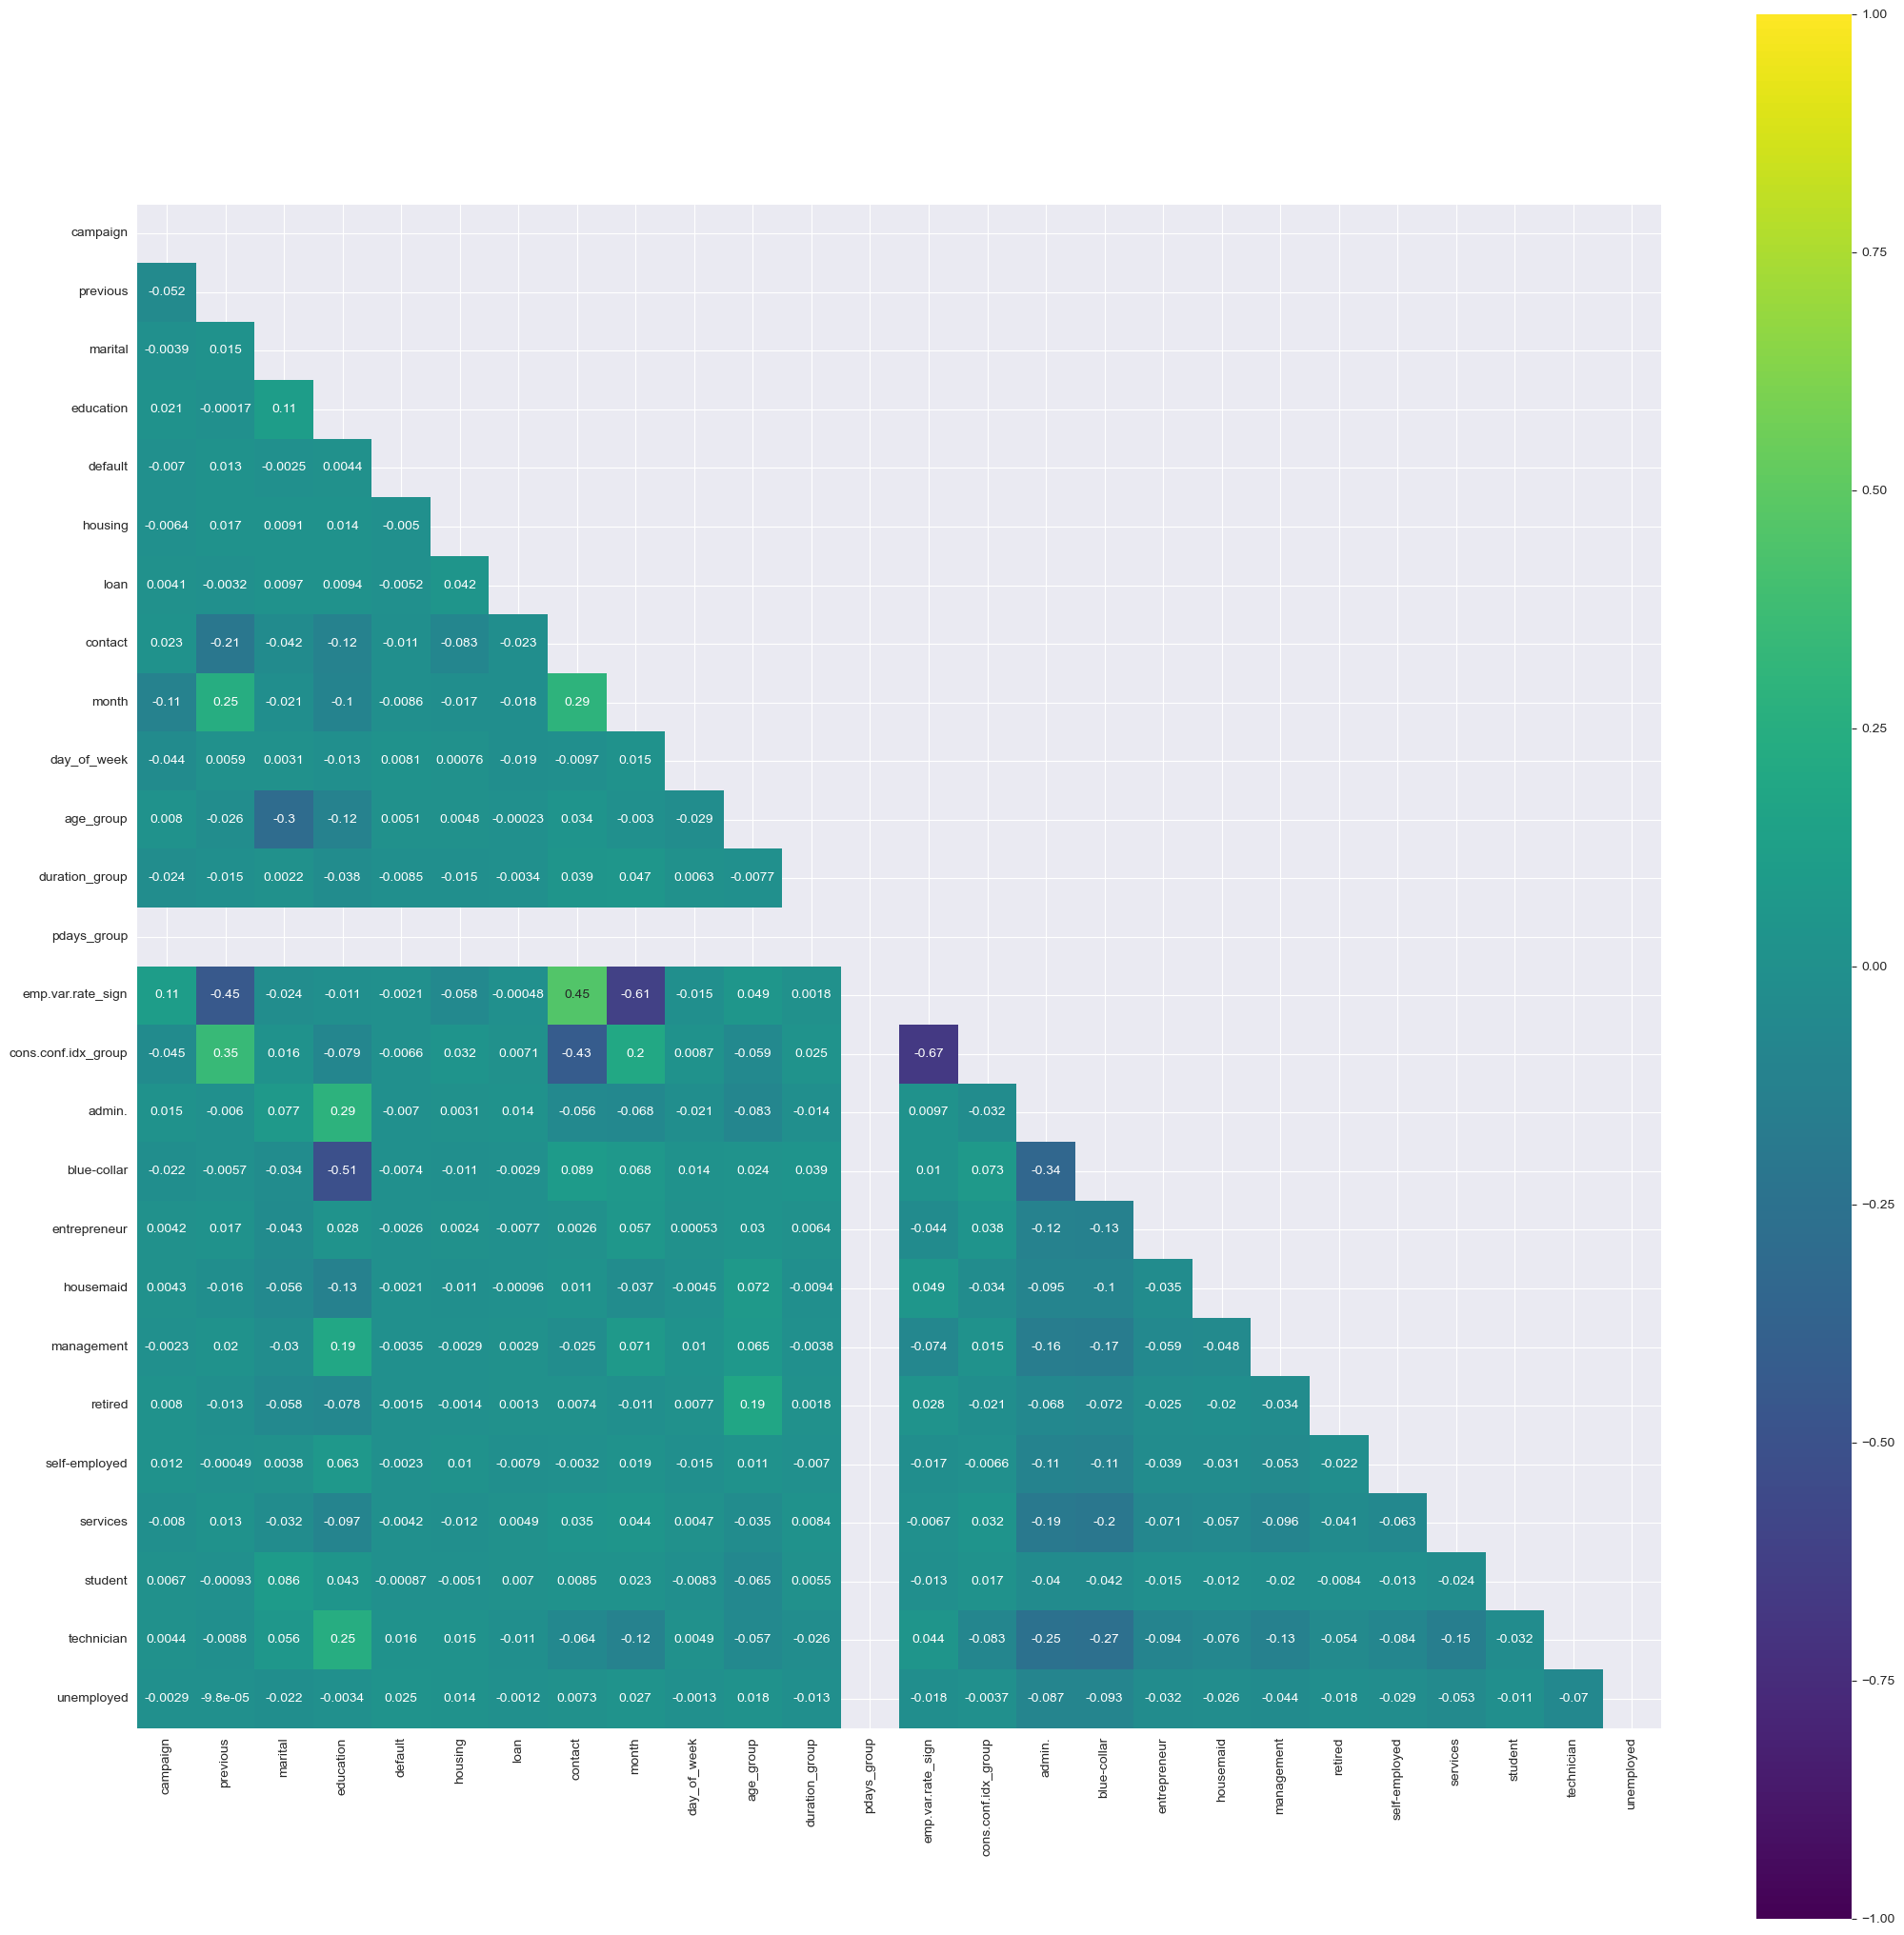

In [2945]:
fig= plt.figure(figsize=(20,20))
df = dataset_selected.drop(['y'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [2946]:
dataset_selected.columns

Index(['campaign', 'previous', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'y', 'age_group',
       'duration_group', 'pdays_group', 'emp.var.rate_sign',
       'cons.conf.idx_group', 'admin.', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services',
       'student', 'technician', 'unemployed'],
      dtype='object')

In [2947]:
dataset_selected.dtypes

campaign                 int64
previous                 int64
marital                  int32
education                int32
default                  int32
housing                  int32
loan                     int32
contact                  int32
month                    int32
day_of_week              int32
y                        int32
age_group                int32
duration_group           int32
pdays_group              int64
emp.var.rate_sign      float64
cons.conf.idx_group      int32
admin.                   int32
blue-collar              int32
entrepreneur             int32
housemaid                int32
management               int32
retired                  int32
self-employed            int32
services                 int32
student                  int32
technician               int32
unemployed               int32
dtype: object

# Feature Sampling:

In [2948]:
dataset_copy.shape

(19619, 37)

In [2949]:
X = dataset_selected.drop(['y'], axis=1)
y = dataset_selected['y']

In [2950]:
X.head()

,campaign,previous,marital,education,default,housing,loan,contact,month,day_of_week,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,1,0,1,0,0,0,0,1,3,1,...,0,0,1,0,0,0,0,0,0,0
2,1,0,1,3,0,1,0,1,3,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,1,1,0,0,0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,3,0,0,1,1,3,1,...,0,0,0,0,0,0,1,0,0,0
5,1,0,1,2,0,0,0,1,3,1,...,0,0,0,0,0,0,1,0,0,0


In [2951]:
counter = Counter(y)
print(f"Before oversampling:{counter}")

oversampling = SMOTE()
X_oversampled, y_smote_sampler = oversampling.fit_resample(X, y)

counter = Counter(y_smote_sampler)
print(f"After oversampling:{counter}")

Before oversampling:Counter({0: 19312, 1: 307})
After oversampling:Counter({0: 19312, 1: 19312})


# Feature Transformation

In [2952]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Apply Min_Max scaler
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

X_minmax = scaler_minmax.fit_transform(X_oversampled)
X_standard = scaler_standard.fit_transform(X_oversampled)

# Feature Selection:

In [2953]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [2954]:
# Prepare dataset for RFE (Recursive Feature Elimination)
def func_RFE_X_rfe(param_X,param_y):
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, step = 4)
    fit = rfe.fit(param_X,param_y)
    selected_features = fit.support_
    X_rfe = param_X[:, selected_features]
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))
    return X_rfe

In [2955]:
# Prepare dataset for SelectKBest (score_func=chi2)
def func_SelectKBest_X_chi2(param_X,param_y):
    test = SelectKBest(score_func=chi2, k=23)
    fit = test.fit(param_X,param_y)
    X_chi2 = fit.transform(param_X)
    return X_chi2

In [2956]:
# Prepare dataset for Ridge
def func_Ridge_X_ridge(param_X,param_y):
    ridge = Ridge(alpha=1.0)
    ridge.fit(param_X,param_y)
    best_alpha = ridge.alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(param_X,param_y)
    selector = SelectFromModel(ridge_model)
    X_ridge = selector.transform(param_X)
    return X_ridge

In [2957]:
# Prepare dataset for MIC (mutual_info_classif)
def func_MIC_X_mic(param_X,param_y):
    mi_scores = MIC(param_X,param_y)
    mi_score_selected_index = np.where(mi_scores <0.2)[0]
    X_mic = param_X[:,mi_score_selected_index]
    mi_scores
    return X_mic

In [2958]:
def print_scores(accuracy_score, recall_score, precision_score, model_name):
    print(f"score_{model_name}:{accuracy_score:10.4f},"
          f"recall score_{model_name}:{recall_score:10.4f},"
          f"precision score_{model_name}:{precision_score:10.4f}")

In [2959]:
def predict_scores(model, x_test, y_test):
    score           = model.score(x_test,y_test)
    y_predict       = model.predict(x_test)
    score_recall    = recall_score(y_predict, y_test)
    score_precision = precision_score(y_predict, y_test)
    return score,score_recall,score_precision

In [2960]:
def func_Calculate_Model_Scores(param_x,param_y, X_chi2, X_rfe, X_ridge, X_mic):
    # Split the data into training and testing sets
    
    X_train, X_test, y_train, y_test                     = train_test_split(param_x,param_y, random_state=0, stratify=param_y)
    X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(X_chi2, param_y, random_state=0, stratify=param_y)
    X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE     = train_test_split(X_rfe, param_y, random_state=0, stratify=param_y)
    X_train_Ridge, X_test_Ridge, y_train_Ridge, y_test_Ridge = train_test_split(X_ridge, param_y, random_state=0, stratify=param_y)
    X_train_MIC, X_test_MIC, y_train_MIC, y_test_MIC     = train_test_split(X_mic, param_y, random_state=0, stratify=param_y)
    RFC = RandomForestClassifier()

    # Compare results with Random Forest Classifier
    model_default = RFC.fit(X_train,y_train)
    score_default, recall_score_default, precision_score_default = predict_scores(model_default,X_test,y_test) 

    model_MIC = RFC.fit(X_train_MIC,y_train_MIC)
    score_MIC, recall_score_MIC, precision_score_MIC = predict_scores(model_MIC,X_test_MIC,y_test_MIC)

    model_chi2 = RFC.fit(X_train_chi2,y_train_chi2)
    score_chi2, recall_score_chi2, precision_score_chi2 = predict_scores(model_chi2,X_test_chi2,y_test_chi2)

    model_RFE = RFC.fit(X_train_RFE,y_train_RFE)
    score_rfe, recall_score_rfe, precision_score_rfe = predict_scores(model_RFE,X_test_RFE,y_test_RFE)

    model_Ridge = RFC.fit(X_train_Ridge,y_train_Ridge)
    score_ridge, recall_score_ridge, precision_score_ridge = predict_scores(model_Ridge,X_test_Ridge,y_test_Ridge)

    #---------------------------------------------------------------------------------
    print_scores(score_MIC, recall_score_MIC, precision_score_MIC, "MIC")
    print_scores(score_rfe, recall_score_rfe, precision_score_rfe, "RFE")
    print_scores(score_chi2, recall_score_chi2, precision_score_chi2, "chi2")
    print_scores(score_ridge, recall_score_ridge, precision_score_ridge, "Ridge")
    print_scores(score_default, recall_score_default, precision_score_default, "default")


In [2961]:
print("Scores for minmax scaler:")
x_chi2 = func_SelectKBest_X_chi2(X_minmax,y_smote_sampler)
x_rfe = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_ridge = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_mic = func_MIC_X_mic(X_minmax,y_smote_sampler)

func_Calculate_Model_Scores(X_minmax, y_smote_sampler, x_chi2, x_rfe, x_ridge, x_mic)

Scores for minmax scaler:
score_MIC:    0.9785,recall score_MIC:    0.9722,precision score_MIC:    0.9851
score_RFE:    0.9272,recall score_RFE:    0.9111,precision score_RFE:    0.9468
score_chi2:    0.9891,recall score_chi2:    0.9860,precision score_chi2:    0.9923
score_Ridge:    0.9270,recall score_Ridge:    0.9086,precision score_Ridge:    0.9495
score_default:    0.9891,recall score_default:    0.9864,precision score_default:    0.9919


In [2962]:
# print("Scores for standard scaler:")
# # Apply Min_Max scaler
# scaler_minmax = MinMaxScaler()
# X_standard_minmax = scaler_minmax.fit_transform(X_standard)
# 
# x_chi2 = func_SelectKBest_X_chi2(X_standard_minmax,y_smote_sampler)
# x_rfe = func_Ridge_X_ridge(X_standard_minmax,y_smote_sampler)
# x_ridge = func_Ridge_X_ridge(X_standard_minmax,y_smote_sampler)
# x_mic = func_MIC_X_mic(X_standard_minmax,y_smote_sampler)
# 
# func_Calculate_Model_Scores(X_minmax, y_smote_sampler, x_chi2, x_rfe, x_ridge, x_mic)

In [2963]:
pd.DataFrame(X_minmax).shape

(38624, 26)

In [2964]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Define a range of numbers of components to experiment with
n_components_range = [17,18,19,20,21,22,23,24,25,26]
for n_components in n_components_range:
    pca = PCA(n_components = n_components)
    X_train_reduced = pca.fit_transform(X_minmax)
    X_test_reduced = pca.transform(X_minmax)

    # Train a linear regression model on the reduced features
    model_reduced = LinearRegression()
    model_reduced.fit(X_train_reduced, y_smote_sampler)

    # Make predictions using the reduced features
    y_pred_reduced = model_reduced.predict(X_test_reduced)

    # Calculate the MSE for this configuration
    mse_reduced = mean_squared_error(y_smote_sampler, y_pred_reduced)

    print(f"MSE (Reduced Features - {n_components} Components): {mse_reduced}")

MSE (Reduced Features - 17 Components): 0.10296012163244708
MSE (Reduced Features - 18 Components): 0.10082059495226633
MSE (Reduced Features - 19 Components): 0.09916005410979717
MSE (Reduced Features - 20 Components): 0.0959888805715838
MSE (Reduced Features - 21 Components): 0.08394640432071694
MSE (Reduced Features - 22 Components): 0.0833731574610302
MSE (Reduced Features - 23 Components): 0.08019546464409416
MSE (Reduced Features - 24 Components): 0.07924364016448347
MSE (Reduced Features - 25 Components): 0.07924345113145982
MSE (Reduced Features - 26 Components): 0.07924345113145981


# Elbow Method

In [2965]:
pca = PCA()
pca.fit(X_minmax)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

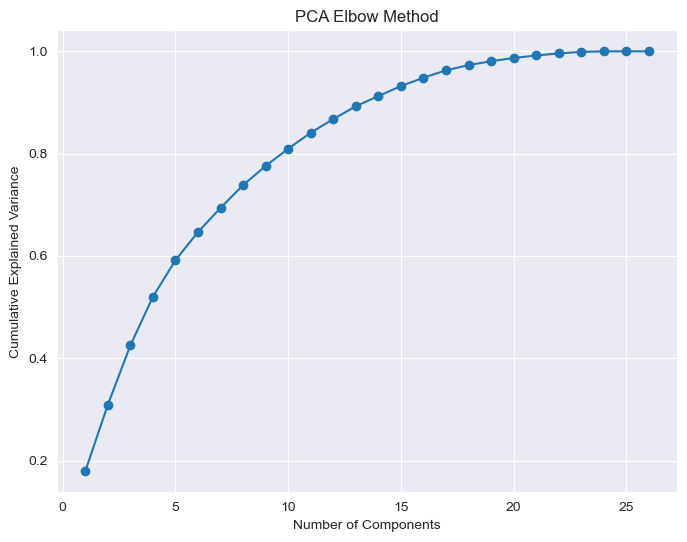

In [2966]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Method')
plt.grid(True)
plt.show()

# Cross-Validation

In [2967]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
# Create your model (classifier, regressor, etc.)
model = SVC()  # Example Support Vector Classifier, replace with your model

# Perform K-fold cross-validation (e.g., 5-fold CV)
cv_scores = cross_val_score(model, X_minmax, y_smote_sampler, cv=8)  # Change cv for different fold sizes

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.94490472 0.96520298 0.97493786 0.96188898 0.9521541  0.93061309
 0.80840928 0.73508699]
Mean CV Accuracy: 0.9091497514498758
